In [1]:
import matplotlib
print(matplotlib.__version__)

3.5.0


In [4]:
!pip install matplotlib==3.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 6.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3


This notebook follows the tutorial attached with https://github.com/ba305/LightGCN-Spotify

In [5]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

# We are installing torch-geometric from a specific GitHub commit instead of from pip wheels/conda. This is because there is currently a bug in
# RandomLinkSplit that has been fixed in the repo, but not yet in an official release. Once release 2.0.3 is available, we can go back
# to installing from pip wheels. See here for more info about the bug: https://github.com/pyg-team/pytorch_geometric/issues/3440
!pip install git+https://github.com/pyg-team/pytorch_geometric.git@7fc1767ece2edd614575dcbff1eb8f79f1035742

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git (to revision 7fc1767ece2edd614575dcbff1eb8f79f1035742) to /tmp/pip-req-build-v_x66ylp
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-v_x66ylp
  Running command git rev-parse -q --verify 'sha^7fc1767ece2edd614575dcbff1eb8f79f1035742'
  Running command git fetch -q https://github.com/pyg-team/pytorch_geometric.git 7fc1767ece2edd614575dcbff1eb8f79f1035742
  Running command git checkout -q 7fc1767ece2edd614575dcbff1eb8f79f1035742
  

In [2]:
import json
import torch
import numpy as np
import os

from torch_geometric import seed_everything
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import degree

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from sklearn.decomposition import PCA
from IPython.display import HTML

seed_everything(42)

In [3]:
#Download preprocessed data from https://github.com/ba305/LightGCN-Spotify
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/data_object.pt
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/dataset_stats.json
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/song_info.json
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/playlist_info.json

--2023-03-03 19:49:44--  https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/data_object.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21104811 (20M) [application/octet-stream]
Saving to: ‘data_object.pt’

data_object.pt      100%[===================>]  20.13M   118MB/s    in 0.2s    

2023-03-03 19:49:46 (118 MB/s) - ‘data_object.pt’ saved [21104811/21104811]

--2023-03-03 19:49:46--  https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/dataset_stats.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, a

In [4]:
#Load data
base_dir = "."
data = torch.load(os.path.join(base_dir, "data_object.pt"))
with open(os.path.join(base_dir, "dataset_stats.json"), 'r') as f:
  stats = json.load(f)
num_playlists, num_nodes = stats['num_playlists'], stats['num_nodes']

We use RandomLinkSplit to split the data into train-test-validation splits since this can otherwise be really complex for GNNs

In [5]:
transform = RandomLinkSplit(is_undirected = True, add_negative_train_samples= False, neg_sampling_ratio = 0, num_val = 0.15, num_test = 0.15)
train_split, val_split, test_split = transform(data)

Message passing edges are directed, and evaluation edges are undirected

In [6]:
print(train_split)
print(val_split)
print(test_split)

Data(edge_index=[2, 923296], num_nodes=14992, edge_label=[461648], edge_label_index=[2, 461648])
Data(edge_index=[2, 923296], num_nodes=14992, edge_label=[98924], edge_label_index=[2, 98924])
Data(edge_index=[2, 1121144], num_nodes=14992, edge_label=[98924], edge_label_index=[2, 98924])


We will make a PyG dataset to use the dataloader to load evaluation edges in batches instead of all at once

In [7]:
#Overrides the __inc__ method because otherwise the DataLoader was incrementing indices unnecessarily
class PlainData(Data):
  def __inc__(self, key, value, *args, **kwargs):
    return 0

In [8]:
class SpotifyDataset(Dataset):
  def __init__(self, root, edge_index, transform = None, pre_transform = None):
    self.edge_index = edge_index
    self.unique_idxs = torch.unique(edge_index[0, :]).tolist() # playlists will all be in row 0, b/c sorted by RandLinkSplit
    self.num_nodes = len(self.unique_idxs)
    super().__init__(root, transform, pre_transform)

  def len(self):
    return self.num_nodes

  def get(self, idx):
    edge_index = self.edge_index[:, self.edge_index[0, :] == idx]
    return PlainData(edge_index = edge_index)

For each split, we have a set of message passing edges (for GNN propagation/getting final multi-scale node embeddings), and also a set of evaluation edges (used to calculate loss/performance metrics). For message passing edges, we can just store them in a PyG Data object. For evaluation edges, we put them in a SpotifyDataset object so we can load them in in batches with a DataLoader.

In [9]:
train_ev = SpotifyDataset('temp', edge_index = train_split.edge_label_index)
train_mp = Data(edge_index = train_split.edge_index)

test_ev = SpotifyDataset('temp', edge_index = test_split.edge_label_index)
test_mp = Data(edge_index = test_split.edge_index)

val_ev = SpotifyDataset('temp', edge_index = val_split.edge_label_index)
val_mp = Data(edge_index = val_split.edge_index)

In [10]:
class LightGCN(MessagePassing):
  def __init__(self):
    super(LightGCN, self).__init__(aggr = 'add')

  def message(self, x_j, norm):
    """
      For LightGCN, we simply pass along each
        source node's embedding to the target node, normalized by the normalization term for that node.

      args:
          x_j: node embeddings of the neighbor nodes, which will be passed to the central node (shape: [E, emb_dim])
          norm: the normalization terms we calculated in forward() and passed into propagate()
      returns:
          messages from neighboring nodes j to central node i
    """
    return norm.view(-1, 1) * x_j

  def forward(self, x, edge_index):
    """
        args:
          x: current node embeddings (shape: [N, emb_dim])
          edge_index: message passing edges (shape: [2, E])
        returns:
          updated embeddings after this layer
    """
    row, col = edge_index
    deg = degree(col)
    deg_inv_sqrt = deg.pow(-0.5)
    norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

    return self.propagate(edge_index, x = x, norm = norm)

In [11]:
class GNN(torch.nn.Module):
    """
    Overall graph neural network. Consists of learnable user/item (i.e., playlist/song) embeddings
    and LightGCN layers.
    """
    def __init__(self, embedding_dim, num_nodes, num_playlists, num_layers):
        super(GNN, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_nodes = num_nodes         # total number of nodes (songs + playlists) in dataset
        self.num_playlists = num_playlists # total number of playlists in dataset
        self.num_layers = num_layers

        # Initialize embeddings for all playlists and songs. Playlists will have indices from 0...num_playlists-1,
        # songs will have indices from num_playlists...num_nodes-1
        self.embeddings = torch.nn.Embedding(num_embeddings=self.num_nodes, embedding_dim=self.embedding_dim)
        torch.nn.init.normal_(self.embeddings.weight, std=0.1)

        self.layers = torch.nn.ModuleList() # LightGCN layers
        for _ in range(self.num_layers):
            self.layers.append(LightGCN())

        self.sigmoid = torch.sigmoid

    def forward(self):
        raise NotImplementedError("forward() has not been implemented for the GNN class. Do not use")

    def gnn_propagation(self, edge_index_mp):
        """
        Performs the linear embedding propagation (using the LightGCN layers) and calculates final (multi-scale) embeddings
        for each user/item, which are calculated as a weighted sum of that user/item's embeddings at each layer (from
        0 to self.num_layers). Technically, the weighted sum here is the average, which is what the LightGCN authors recommend.

        args:
          edge_index_mp: a tensor of all (undirected) edges in the graph, which is used for message passing/propagation and
              calculating the multi-scale embeddings. (In contrast to the evaluation/supervision edges, which are distinct
              from the message passing edges and will be used for calculating loss/performance metrics).
        returns:
          final multi-scale embeddings for all users/items
        """
        x = self.embeddings.weight        # layer-0 embeddings

        x_at_each_layer = [x]             # stores embeddings from each layer. Start with layer-0 embeddings
        for i in range(self.num_layers):  # now performing the GNN propagation
            x = self.layers[i](x, edge_index_mp)
            x_at_each_layer.append(x)
        final_embs = torch.stack(x_at_each_layer, dim=0).mean(dim=0) # take average to calculate multi-scale embeddings
        return final_embs

    def predict_scores(self, edge_index, embs):
        """
        Calculates predicted scores for each playlist/song pair in the list of edges. Uses dot product of their embeddings.

        args:
          edge_index: tensor of edges (between playlists and songs) whose scores we will calculate.
          embs: node embeddings for calculating predicted scores (typically the multi-scale embeddings from gnn_propagation())
        returns:
          predicted scores for each playlist/song pair in edge_index
        """
        scores = embs[edge_index[0,:], :] * embs[edge_index[1,:], :] # taking dot product for each playlist/song pair
        scores = scores.sum(dim=1)
        scores = self.sigmoid(scores)
        return scores

    def calc_loss(self, data_mp, data_pos, data_neg):
        """
        The main training step. Performs GNN propagation on message passing edges, to get multi-scale embeddings.
        Then predicts scores for each training example, and calculates Bayesian Personalized Ranking (BPR) loss.

        args:
          data_mp: tensor of edges used for message passing / calculating multi-scale embeddings
          data_pos: set of positive edges that will be used during loss calculation
          data_neg: set of negative edges that will be used during loss calculation
        returns:
          loss calculated on the positive/negative training edges
        """
        # Perform GNN propagation on message passing edges to get final embeddings
        final_embs = self.gnn_propagation(data_mp.edge_index)

        # Get edge prediction scores for all positive and negative evaluation edges
        pos_scores = self.predict_scores(data_pos.edge_index, final_embs)
        neg_scores = self.predict_scores(data_neg.edge_index, final_embs)

        # # Calculate loss (binary cross-entropy). Commenting out, but can use instead of BPR if desired.
        # all_scores = torch.cat([pos_scores, neg_scores], dim=0)
        # all_labels = torch.cat([torch.ones(pos_scores.shape[0]), torch.zeros(neg_scores.shape[0])], dim=0)
        # loss_fn = torch.nn.BCELoss()
        # loss = loss_fn(all_scores, all_labels)

        # Calculate loss (using variation of Bayesian Personalized Ranking loss, similar to the one used in official
        # LightGCN implementation at https://github.com/gusye1234/LightGCN-PyTorch/blob/master/code/model.py#L202)
        loss = -torch.log(self.sigmoid(pos_scores - neg_scores)).mean()
        return loss

    def evaluation(self, data_mp, data_pos, k):
        """
        Performs evaluation on validation or test set. Calculates recall@k.

        args:
          data_mp: message passing edges to use for propagation/calculating multi-scale embeddings
          data_pos: positive edges to use for scoring metrics. Should be no overlap between these edges and data_mp's edges
          k: value of k to use for recall@k
        returns:
          dictionary mapping playlist ID -> recall@k on that playlist
        """
        # Run propagation on the message-passing edges to get multi-scale embeddings
        final_embs = self.gnn_propagation(data_mp.edge_index)

        # Get embeddings of all unique playlists in the batch of evaluation edges
        unique_playlists = torch.unique_consecutive(data_pos.edge_index[0,:])
        playlist_emb = final_embs[unique_playlists, :] # has shape [number of playlists in batch, 64]
        
        # Get embeddings of ALL songs in dataset
        song_emb = final_embs[self.num_playlists:, :] # has shape [total number of songs in dataset, 64]

        # All ratings for each playlist in batch to each song in entire dataset (using dot product as the scoring function)
        ratings = self.sigmoid(torch.matmul(playlist_emb, song_emb.t())) # shape: [# playlists in batch, # songs in dataset]
                                                                         # where entry i,j is rating of song j for playlist i
        # Calculate recall@k
        result = recall_at_k(ratings.cpu(), k, self.num_playlists, data_pos.edge_index.cpu(), 
                             unique_playlists.cpu(), data_mp.edge_index.cpu())
        return result

In [12]:
def recall_at_k(all_ratings, k , num_playlists, ground_truth, unique_playlists, data_mp):
  """
   Calculates recall@k during validation/testing for a single batch.

   args:
     all_ratings: array of shape [number of playlists in batch, number of songs in whole dataset]
     k: the value of k to use for recall@k
     num_playlists: the number of playlists in the dataset
     ground_truth: array of shape [2, X] where each column is a pair of (playlist_idx, positive song idx). This is the
        batch that we are calculating metrics on.
     unique_playlists: 1D vector of length [number of playlists in batch], which specifies which playlist corresponds
        to each row of all_ratings
     data_mp: an array of shape [2, Y]. This is all of the known message-passing edges. We will use this to make sure we
        don't recommend songs that are already known to be in the playlist.
   returns:
     Dictionary of playlist ID -> recall@k on that playlist
  """
  # We don't want to recommend songs that are already known to be in the playlist! 
  # Set those to a low rating so they won't be recommended
  known_edges = data_mp[:, data_mp[0, :] < num_playlists] # removing duplicate edges (since data_mp is undirected). also makes it so
  # that for each column, playlist idx is in row 0 and song idx is in row 1

  playlist_to_idx_in_batch = {playlist: i for i, playlist in enumerate(unique_playlists.tolist())}
  exclude_playlists, exclude_songs = [], [] # already-known playlist/song links. Don't want to recommend these again
  for i in range(known_edges.shape[1]):
    pl, song = known_edges[:, i].tolist()
    if pl in playlist_to_idx_in_batch: 
      exclude_playlists.append(playlist_to_idx_in_batch[pl])
      exclude_songs.append(song - num_playlists)
  all_ratings[exclude_playlists, exclude_songs] = -10000 # setting to a very low score so they won't be recommended

  # Get top k recommendations for each playlist
  _, top_k = torch.topk(all_ratings, k = k, dim = 1)
  top_k += num_playlists

  # Calculate recall@k
  recall = {}
  for i, playlist in enumerate(unique_playlists):
    pos_songs = ground_truth[1, ground_truth[0, :] == playlist]
    k_recs = top_k[i, :]
    rec = len(np.intersect1d(pos_songs, k_recs)) / len(pos_songs)
    recall[playlist] = rec
  return recall

Also, during training, to calculate the Bayesian Personalized Ranking (BPR) loss, we will need to sample negative edges. Here is a function that does that. 

Note that to sample negatives, we randomly select songs for each playlist without checking if they are true negatives, since that is computationally expensive. This is fine in our case, because we will never be sampling more than ~100 songs for a playlist (out of thousands of songs), so although we will accidentally sample some positive songs occasionally, it will be an acceptably small number. However, if that is not the case for your dataset, please consider modifying this function to sample true negatives only. 

In [13]:
def sample_negative_edges(batch, num_playlists, num_nodes):
  negs = []
  for i in batch.edge_index[0, :]:
    assert i < num_playlists
    rand = torch.randint(num_playlists, num_nodes, (1, ))
    negs.append(rand.item())
  edge_index_negs = torch.row_stack([batch.edge_index[0, :], torch.LongTensor(negs)])

  return Data(edge_index = edge_index_negs)

In [14]:
def train(model, data_mp, loader, opt, num_playlists, num_nodes, device):
  """
    Main training loop

    args:
       model: the GNN model
       data_mp: message passing edges to use for performing propagation/calculating multi-scale embeddings
       loader: DataLoader that loads in batches of supervision/evaluation edges
       opt: the optimizer
       num_playlists: the number of playlists in the entire dataset
       num_nodes: the number of nodes (playlists + songs) in the entire dataset
       device: whether to run on CPU or GPU
    returns:
       the training loss for this epoch
  """
  total_loss = 0
  total_examples = 0
  model.train()

  for batch in loader:
    del batch.batch; del batch.ptr #unwanted attributes

    opt.zero_grad()
    negs = sample_negative_edges(batch, num_playlists, num_nodes)
    data_mp, batch, negs = data_mp.to(device), batch.to(device), negs.to(device)
    loss = model.calc_loss(data_mp, batch, negs)
    loss.backward()
    opt.step()

    num_examples = batch.edge_index.shape[1]
    total_loss += loss.item() * num_examples
    total_examples += num_examples

  avg_loss = total_loss / total_examples
  return avg_loss

In [15]:
def test(model, data_mp, loader, k, device, save_dir, epoch):
    """
    Evaluation loop for validation/testing.

    args:
       model: the GNN model
       data_mp: message passing edges to use for propagation/calculating multi-scale embeddings
       loader: DataLoader that loads in batches of evaluation (i.e., validation or test) edges
       k: value of k to use for recall@k
       device: whether to use CPU or GPU
       save_dir: directory to save multi-scale embeddings for later analysis. If None, doesn't save any embeddings.
       epoch: the number of the current epoch
    returns:
       recall@k for this epoch
    """
    model.eval()
    all_recalls = {}
    with torch.no_grad():
        # Save multi-scale embeddings if save_dir is not None
        data_mp = data_mp.to(device)
        if save_dir is not None:
            embs_to_save = gnn.gnn_propagation(data_mp.edge_index)
            torch.save(embs_to_save, os.path.join(save_dir, f"embeddings_epoch_{epoch}.pt"))

        # Run evaluation
        for batch in loader:
            del batch.batch; del batch.ptr # delete unwanted attributes

            batch = batch.to(device)
            recalls = model.evaluation(data_mp, batch, k)
            for playlist_idx in recalls:
                assert playlist_idx not in all_recalls
            all_recalls.update(recalls)
    recall_at_k = np.mean(list(all_recalls.values()))
    return recall_at_k

In [16]:
num_songs = num_nodes - num_playlists
print(f"There are {num_songs} unique songs in the dataset")
print (300 / num_songs)

There are 5696 unique songs in the dataset
0.05266853932584269


In [17]:
epochs = 100
k = 300
num_layers = 3
batch_size = 2048
embedding_dim = 64
save_embedding_dir = 'embeddings'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
# Make directory to save embeddings
if save_embedding_dir is not None:
  os.mkdir(save_embedding_dir)

In [19]:
train_loader = DataLoader(train_ev, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ev, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ev, batch_size=batch_size, shuffle=False)

In [20]:
gnn = GNN(embedding_dim = embedding_dim, num_nodes = data.num_nodes, num_playlists = num_playlists, num_layers = num_layers).to(device)
opt = torch.optim.Adam(gnn.parameters(), lr=1e-3)

In [21]:
all_train_losses = [] # list of (epoch, training loss)
all_val_recalls = []  # list of (epoch, validation recall@k)

# Main training loop
for epoch in range(epochs):
    train_loss = train(gnn, train_mp, train_loader, opt, num_playlists, num_nodes, device)
    all_train_losses.append((epoch, train_loss))
    
    if epoch in range(11) or epoch % 5 == 0: # perform validation for the first ~10 epochs, then every 5 epochs after that
        val_recall = test(gnn, val_mp, val_loader, k, device, save_embedding_dir, epoch)
        all_val_recalls.append((epoch, val_recall))
        print(f"Epoch {epoch}: train loss={train_loss}, val_recall={val_recall}")
    else:
        print(f"Epoch {epoch}: train loss={train_loss}")


print()

# Print best validation recall@k value
best_val_recall = max(all_val_recalls, key = lambda x: x[1])
print(f"Best validation recall@k: {best_val_recall[1]} at epoch {best_val_recall[0]}")

# Print final recall@k on test set
test_recall = test(gnn, test_mp, test_loader, k, device, None, None)
print(f"Test set recall@k: {test_recall}")

/usr/local/lib/python3.8/dist-packages/torch_geometric/data/storage.py:259: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Epoch 0: train loss=0.6929594556751733, val_recall=0.06582217344802543
Epoch 1: train loss=0.6928735408069885, val_recall=0.08843551778532457
Epoch 2: train loss=0.6927239257770387, val_recall=0.1324154354748938
Epoch 3: train loss=0.6924787398971418, val_recall=0.1952350334965821
Epoch 4: train loss=0.6920864450619819, val_recall=0.25885919072417424
Epoch 5: train loss=0.6915116771822964, val_recall=0.3099654589958242
Epoch 6: train loss=0.6907056141814499, val_recall=0.34639071096348395
Epoch 7: train loss=0.6896348629130417, val_recall=0.36872662091714065
Epoch 8: train loss=0.6882466827342838, val_recall=0.3803408875431212
Epoch 9: train loss=0.6865277842625336, val_recall=0.38793141144310994
Epoch 10: train loss=0.6844210646899636, val_recall=0.39231182792559954
Epoch 11: train loss=0.6819643744688786
Epoch 12: train loss=0.6790800550336363
Epoch 13: train loss=0.6758818549051067
Epoch 14: train loss=0.6722483687076714
Epoch 15: train loss=0.6682221711116251, val_recall=0.39428573

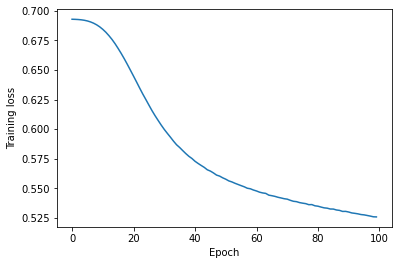

In [22]:
plt.plot([x[0] for x in all_train_losses], [x[1] for x in all_train_losses])
plt.xlabel("Epoch")
plt.ylabel("Training loss")

plt.show()

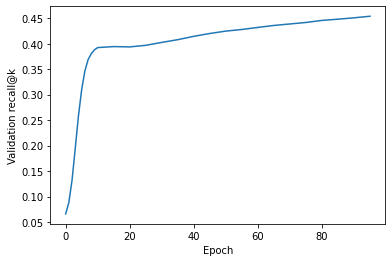

In [23]:
plt.plot([x[0] for x in all_val_recalls], [x[1] for x in all_val_recalls])
plt.xlabel("Epoch")
plt.ylabel("Validation recall@k")
plt.show()

In [24]:
pca_embs = []
for i in range(11): # just visualizing epochs 0-10
    embs = torch.load(os.path.join('embeddings/embeddings_epoch_' + str(i) + '.pt'), map_location=torch.device('cpu'))
    pca = PCA(n_components=2).fit_transform(embs)
    pca_embs.append(pca)

In [25]:
# Load playlist/song details
with open('playlist_info.json', 'r') as f:
  playlists = json.load(f)
  playlists = {int(k): v for k, v in playlists.items()}

with open('song_info.json', 'r') as f:
  songs = json.load(f)
  songs = {int(k): v for k, v in songs.items()}

In [26]:
# Find all playlists with "rock" in the title
rock = []
rock_colors = [] # colors for plotting
for id in playlists:
    name = playlists[id]['name'].lower()
    if 'rock' in name:
        rock.append(rock)
        rock_colors.append(0)
    else:
        rock_colors.append(1)

In [27]:
print(f"There are {len(rock)} rock playlists out of {len(playlists)} total playlists")

There are 281 rock playlists out of 9296 total playlists


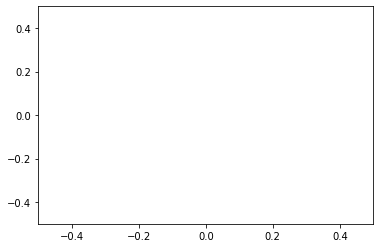

In [28]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( -0.5, 0.5))
ax.set_ylim((-0.5, 0.5))

colors = ['red', 'skyblue']
from matplotlib.colors import ListedColormap
cmap = ListedColormap(colors)


scat = ax.scatter([], [], c=[], s=3, alpha=0.3, cmap=cmap)

# NOTE: this plot below will be empty! Just ignore it and go to the next cell

In [29]:
def init():
    scat.set_offsets([])
    return scat,

In [30]:
def animate(i):
  embs = pca_embs[i]
  x, y = embs[:num_playlists, 0], embs[:num_playlists, 1] # only plotting playlists, not songs
  data = np.hstack((x[:,np.newaxis], y[:, np.newaxis]))
  scat.set_offsets(data)
  scat.set_array(rock_colors)
  return (scat,)

In [31]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=11, interval=1000, blit=True)

In [32]:
HTML(anim.to_html5_video())

### Visualizing Beyonce Songs

In [39]:
bey_id = 'spotify:artist:6vWDO969PvNqNYHIOW5v0m'
bey = []
bey_colors = [] # colors for plotting
bey_sizes = []  # sizes of the points when plotting
for id in songs:
    if songs[id]['artist_uri'] == bey_id:
      bey.append(id)
      bey_colors.append(0)
      bey_sizes.append(15)
    else:
      bey_colors.append(1)
      bey_sizes.append(3)

In [40]:
print(f"There are {len(bey)} Beyonce songs in the dataset")

There are 26 Beyonce songs in the dataset


In [41]:
colors = ['red', 'skyblue']
cmap_bey = ListedColormap(colors)

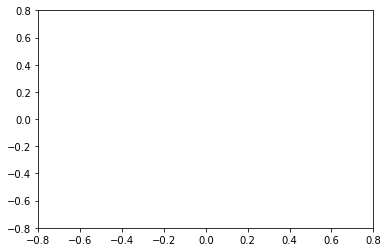

In [43]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( -0.8, 0.8))
ax.set_ylim((-0.8, 0.8))

scat = ax.scatter([], [], c=[], s=[], alpha=0.3, cmap=cmap_bey)

# NOTE: this plot will be empty! Just ignore it and continue to the next cell

In [44]:
def init():
    scat.set_offsets([])
    return scat,

In [45]:
def animate(i):
  embs = pca_embs[i]
  x, y = embs[num_playlists:, 0], embs[num_playlists:, 1] # only plotting songs, not playlists
  data = np.hstack((x[:,np.newaxis], y[:, np.newaxis]))
  scat.set_offsets(data)
  scat.set_array(bey_colors)
  scat.set_sizes(bey_sizes)
  return (scat,)

In [46]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=11, interval=1000, blit=True)

In [47]:
HTML(anim.to_html5_video())